### Load SP500 stocks prices data.

In [7]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import os
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-05-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-02 A        43.071739   45.900002   46.150002   45.820000   45.910000   
           AAL      30.435608   31.670000   32.070000   31.580000   31.670000   
           AAPL     22.438631   24.430000   24.459999   24.157499   24.400000   
           ABBV     46.128258   65.089996   65.150002   62.830002   62.869999   
           ABT      34.118511   39.529999   39.639999   39.349998   39.500000   
...                       ...         ...         ...         ...         ...   
2024-05-30 XYL     139.399994  139.399994  140.160004  137.059998  138.050003   
           YUM     134.839996  134.839996  135.490005  134.360001  135.059998   
           ZBH     114.440002  114.440002  116.220001  114.370003  115.459999   
           ZBRA    316.619995  316.619995  319.549988  315.309998  319.549988   
           ZTS     169.440002  169.440002  174.169998  168.309998  170.679993   

Price                   volume  
date       ticker               
2016-06-02 A         2209400.0  
           AAL       6813300.0  
           AAPL    160766400.0  
           ABBV     11628000.0  
           ABT      12758500.0  
...                        ...  
2024-05-30 XYL       1751500.0  
           YUM       1587600.0  
           ZBH       1731100.0  
           ZBRA       233800.0  
           ZTS       2904700.0  

[992563 rows x 6 columns]

### Calculate features and technical indicators for each stock.
- Garman-Klass Volatility: A volatility measure that considers the high, low, opening, and closing prices to estimate the price variability. It is considered more accurate than traditional measures like standard deviation

- RSI (Relative Strength Index): A momentum oscillator that measures the speed and change of price movements, usually over a 14-period interval. An RSI above 70 indicates overbought conditions, while an RSI below 30 indicates oversold conditions.

- Bollinger Bands: Consist of three lines – the middle band is a simple moving average, and the upper and lower bands are standard deviations away from the middle band. They provide a relative definition of high and low prices.

- ATR (Average True Range): Measures market volatility by decomposing the entire range of an asset price for a given period. It is used to identify potential breakouts and volatility.

- MACD (Moving Average Convergence Divergence): A trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. It helps identify potential buy and sell signals.

- Dollar Volume: Represents the total traded value of a stock, calculated by multiplying the adjusted closing price by the volume and converting it into millions. It helps identify stocks with high trading activity.

In [8]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-02 A        43.071739   45.900002   46.150002   45.820000   45.910000   
           AAL      30.435608   31.670000   32.070000   31.580000   31.670000   
           AAPL     22.438631   24.430000   24.459999   24.157499   24.400000   
           ABBV     46.128258   65.089996   65.150002   62.830002   62.869999   
           ABT      34.118511   39.529999   39.639999   39.349998   39.500000   
...                       ...         ...         ...         ...         ...   
2024-05-30 XYL     139.399994  139.399994  140.160004  137.059998  138.050003   
           YUM     134.839996  134.839996  135.490005  134.360001  135.059998   
           ZBH     114.440002  114.440002  116.220001  114.370003  115.459999   
           ZBRA    316.619995  316.619995  319.549988  315.309998  319.549988   
           ZTS     169.440002  169.440002  174.169998  168.309998  170.679993   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-02 A         2209400.0         -0.001547        NaN       NaN   
           AAL       6813300.0         -0.000492        NaN       NaN   
           AAPL    160766400.0         -0.002635        NaN       NaN   
           ABBV     11628000.0         -0.036380        NaN       NaN   
           ABT      12758500.0         -0.008259        NaN       NaN   
...                        ...               ...        ...       ...   
2024-05-30 XYL       1751500.0          0.000214  55.550949  4.919935   
           YUM       1587600.0          0.000034  44.662510  4.897556   
           ZBH       1731100.0          0.000098  34.666275  4.750956   
           ZBRA       233800.0          0.000056  55.681767  5.740694   
           ZTS       2904700.0          0.000565  52.105516  5.109968   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-06-02 A            NaN       NaN       NaN       NaN      95.162701  
           AAL          NaN       NaN       NaN       NaN     207.366927  
           AAPL         NaN       NaN       NaN       NaN    3607.377936  
           ABBV         NaN       NaN       NaN       NaN     536.379381  
           ABT          NaN       NaN       NaN       NaN     435.301025  
...                     ...       ...       ...       ...            ...  
2024-05-30 XYL     4.958433  4.996931  0.642582  1.135583     244.159089  
           YUM     4.926031  4.954507  0.309709 -0.495136     214.071978  
           ZBH     4.788652  4.826347 -0.749859 -0.802326     198.107088  
           ZBRA    5.769247  5.797800 -0.209171  0.676880      74.025755  
           ZTS     5.141643  5.173318  0.703673  0.711357     492.172375  

[992563 rows x 14 columns]

## Aggregate to monthly level and filter top 150 most liquid stocks for each month.
- To reduce training time and experiment with features and strategies, convert the business-daily data to month-end frequency.

In [9]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-07-31 A           75.466175   45.264519         -0.000743  63.936206   
           AAL        401.105356   34.116329         -0.000845  59.692626   
           AAPL      3118.136325   23.928875         -0.002745  67.567910   
           ABBV       350.139822   47.348202         -0.039624  65.472486   
           ABT        403.487973   38.861832         -0.006625  76.719099   
...                          ...         ...               ...        ...   
2024-05-31 XYL        201.683559  139.399994          0.000214  55.550949   
           YUM        264.300751  134.839996          0.000034  44.662510   
           ZBH        161.764632  114.440002          0.000098  34.666275   
           ZBRA        95.590943  316.619995          0.000056  55.681767   
           ZTS        444.613940  169.440002          0.000565  52.105516   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-07-31 A       3.746726  3.795039  3.843352 -1.321277  0.095989  
           AAL     3.334677  3.509816  3.684955  0.652664  1.810152  
           AAPL    3.110997  3.162217  3.213437 -1.217319 -0.112978  
           ABBV    3.809448  3.841618  3.873788 -1.328258  0.179465  
           ABT     3.562258  3.628716  3.695173 -1.215201  0.815596  
...                     ...       ...       ...       ...       ...  
2024-05-31 XYL     4.919935  4.958433  4.996931  0.642582  1.135583  
           YUM     4.897556  4.926031  4.954507  0.309709 -0.495136  
           ZBH     4.750956  4.788652  4.826347 -0.749859 -0.802326  
           ZBRA    5.740694  5.769247  5.797800 -0.209171  0.676880  
           ZTS     5.109968  5.141643  5.173318  0.703673  0.711357  

[46861 rows x 9 columns]

- Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [10]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-06-30 AAL      48.838978         -0.000020  59.919035  3.858655   
           AAPL     33.703403         -0.001808  43.606666  3.515703   
           ABBV     53.369362         -0.036447  71.506229  3.924985   
           ABT      43.018219         -0.006063  67.057090  3.734658   
           ACN     111.341927         -0.003969  49.971654  4.703720   
...                       ...               ...        ...       ...   
2024-05-31 VZ       40.330002          0.000139  53.645621  3.682184   
           WFC      59.209999          0.000073  49.647755  4.087612   
           WMT      64.889999          0.000019  67.387916  4.072496   
           XOM     113.989998          0.000038  45.434773  4.732214   
           ZTS     169.440002          0.000565  52.105516  5.109968   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-06-30 AAL     3.891033  3.923412  0.508692  0.706176  
           AAPL    3.567603  3.619503 -1.085334 -0.452410  
           ABBV    3.972575  4.020166 -1.528941  0.404156  
           ABT     3.772220  3.809783 -1.332634  0.466137  
           ACN     4.735047  4.766373 -1.096257 -0.200666  
...                     ...       ...       ...       ...  
2024-05-31 VZ      3.707925  3.733666 -0.695211 -0.141973  
           WFC     4.119678  4.151744 -0.261138  0.109598  
           WMT     4.149212  4.225929  0.943250  2.638468  
           XOM     4.763441  4.794668  0.534310 -0.668915  
           ZTS     5.141643  5.173318  0.703673  0.711357  

[12516 rows x 8 columns]

## Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [11]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-06-30 AAL      37.156162         -0.000030  30.484752  3.636104   
           AAPL     43.992641         -0.000987  49.582458  3.786773   
           ABBV     70.505760         -0.029046  38.080565  4.251017   
           ABT      55.062889         -0.004588  47.018593  4.017404   
           ACN     150.009064         -0.003033  58.053316  4.970734   
...                       ...               ...        ...       ...   
2024-05-31 VRTX    443.049988          0.000122  61.749589  5.987989   
           VZ       40.330002          0.000139  53.645621  3.682184   
           WFC      59.209999          0.000073  49.647755  4.087612   
           WMT      64.889999          0.000019  67.387916  4.072496   
           XOM     113.989998          0.000038  45.434773  4.732214   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-06-30 AAL     3.737324  3.838545  0.674891 -1.730625  -0.128158   
           AAPL    3.824281  3.861789 -1.025586 -0.318015  -0.009418   
           ABBV    4.313625  4.376233 -0.282616 -1.213119  -0.063574   
           ABT     4.047169  4.076934 -0.961081 -0.326826  -0.008776   
           ACN     5.002521  5.034309 -0.632781  0.032202   0.050404   
...                     ...       ...       ...       ...        ...   
2024-05-31 VRTX    6.068846  6.149703  1.103330  2.382500   0.127899   
           VZ      3.707925  3.733666 -0.695211 -0.141973   0.021271   
           WFC     4.119678  4.151744 -0.261138  0.109598   0.003884   
           WMT     4.149212  4.225929  0.943250  2.638468   0.097129   
           XOM     4.763441  4.794668  0.534310 -0.668915  -0.028360   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526  
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040165   0.024443   0.012599   0.023607    0.025152  
...                      ...        ...        ...        ...         ...  
2024-05-31 VRTX     0.029516   0.017372   0.037710   0.027083    0.026535  
           VZ      -0.011709   0.007958   0.014039   0.022042    0.016430  
           WFC      0.013627   0.023205   0.050625   0.043367    0.036170  
           WMT      0.040278   0.036878   0.039771   0.021394    0.024380  
           XOM     -0.005712   0.032112   0.020414   0.005718    0.012071  

[10368 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
- Introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- Access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [12]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

/var/folders/11/wnc852jj5wj57yyc4fvtw9gw0000gn/T/ipykernel_65092/1016428129.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
/var/folders/11/wnc852jj5wj57yyc4fvtw9gw0000gn/T/ipykernel_65092/1016428129.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10226 rows x 6 columns]

- Filter out stocks with less than 10 months of data.

In [13]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10184 rows x 6 columns]

- Calculate Rolling Factor Betas.

In [14]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.445599 -1.036032  0.572285  0.109182 -0.072939
           WFC     1.099293  0.259486  1.225701 -0.520460 -0.781069
           WMT     0.609517  0.128332 -0.665666  0.617155  0.467725
           XOM     0.792478 -0.105619  0.684627  0.877219  0.323780

[10184 rows x 5 columns]

- Join the rolling factors data to the main features dataframe.

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10195 entries, (Timestamp('2018-06-30 00:00:00'), 'AAL') to (Timestamp('2024-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10195 non-null  float64
 1   rsi               10195 non-null  float64
 2   bb_low            10195 non-null  float64
 3   bb_mid            10195 non-null  float64
 4   bb_high           10195 non-null  float64
 5   atr               10195 non-null  float64
 6   macd              10195 non-null  float64
 7   return_1m         10195 non-null  float64
 8   return_2m         10195 non-null  float64
 9   return_3m         10195 non-null  float64
 10  return_6m         10195 non-null  float64
 11  return_9m         10195 non-null  float64
 12  return_12m        10195 non-null  float64
 13  Mkt-RF            10195 non-null  float64
 14  SMB               10195 non-null  float64
 15  HML        

## For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
### K-Means Clustering
- Pre-define our centroids for each cluster.

In [16]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [17]:
from sklearn.cluster import KMeans


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluste

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-06-30 AAL            -0.000030  30.484752  3.636104  3.737324  3.838545   
           AAPL           -0.000987  49.582458  3.786773  3.824281  3.861789   
           ABBV           -0.029046  38.080565  4.251017  4.313625  4.376233   
           ABT            -0.004588  47.018593  4.017404  4.047169  4.076934   
           ACN            -0.003033  58.053316  4.970734  5.002521  5.034309   
...                             ...        ...       ...       ...       ...   
2024-05-31 VRTX            0.000122  61.749589  5.987989  6.068846  6.149703   
           VZ              0.000139  53.645621  3.682184  3.707925  3.733666   
           WFC             0.000073  49.647755  4.087612  4.119678  4.151744   
           WMT             0.000019  67.387916  4.072496  4.149212  4.225929   
           XOM             0.000038  45.434773  4.732214  4.763441  4.794668   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-06-30 AAL     0.674891 -1.730625  -0.128158  -0.058566  -0.098656   
           AAPL   -1.025586 -0.318015  -0.009418   0.060393   0.034635   
           ABBV   -0.282616 -1.213119  -0.063574  -0.020405  -0.003677   
           ABT    -0.961081 -0.326826  -0.008776   0.024305   0.007529   
           ACN    -0.632781  0.032202   0.050404   0.040165   0.024443   
...                     ...       ...        ...        ...        ...   
2024-05-31 VRTX    1.103330  2.382500   0.127899   0.029516   0.017372   
           VZ     -0.695211 -0.141973   0.021271  -0.011709   0.007958   
           WFC    -0.261138  0.109598   0.003884   0.013627   0.023205   
           WMT     0.943250  2.638468   0.097129   0.040278   0.036878   
           XOM     0.534310 -0.668915  -0.028360  -0.005712   0.032112   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.210618  1.478019   
           AAPL     0.016401   0.021872    0.022450  1.320013 -0.351195   
           ABBV    -0.004230   0.007379    0.023476  0.471460  0.528306   
           ABT      0.012748   0.016592    0.020784  0.794373 -0.140728   
           ACN      0.012599   0.023607    0.025152  1.215285 -0.186488   
...                      ...        ...         ...       ...       ...   
2024-05-31 VRTX     0.037710   0.027083    0.026535  0.512417  0.077153   
           VZ       0.014039   0.022042    0.016430  0.470877 -0.438164   
           WFC      0.050625   0.043367    0.036170  1.082589 -0.098301   
           WMT      0.039771   0.021394    0.024380  0.610215 -0.395167   
           XOM      0.020414   0.005718    0.012071  1.080433  0.163427   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.440366  0.141759  0.818151        0  
           AAPL   -0.620631  0.441307  0.617803        3  
           ABBV   -0.198819  0.540638  0.439541        0  
           ABT    -0.447361  0.257611  0.940056        1  
           ACN    -0.260764  0.331319  0.101017        3  
...                     ...       ...       ...      ...  
2024-05-31 VRTX   -0.895089  0.058607  0.854899        1  
           VZ      0.209230  0.210785  0.255771        2  
           WFC     1.564557 -0.755425 -0.839035        2  
           WMT    -0.368604  0.229217  0.692205        1  
           XOM     0.821279 -0.478978  0.466571        3  

[10195 rows x 19 columns]

In [18]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

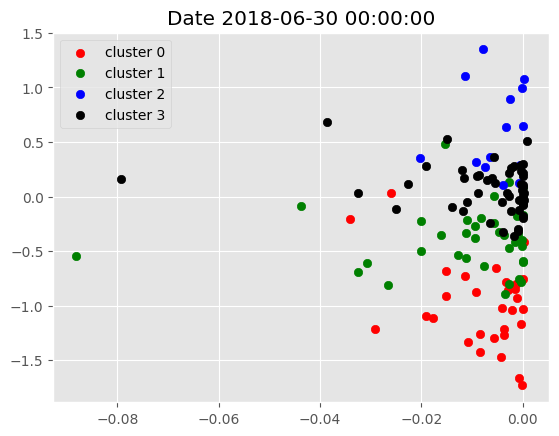

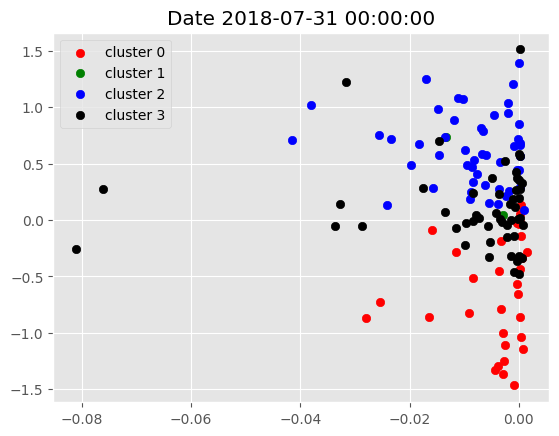

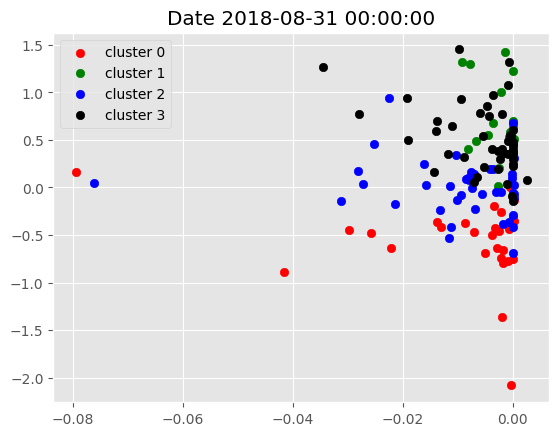

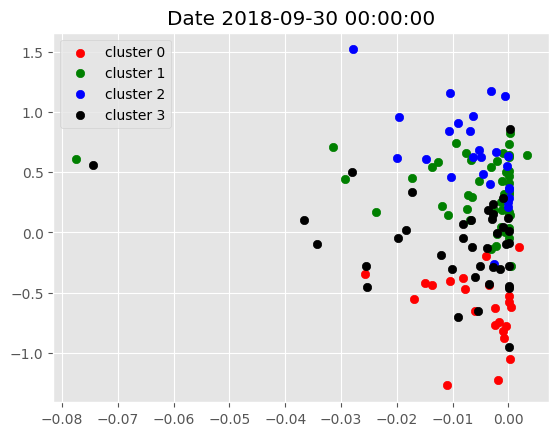

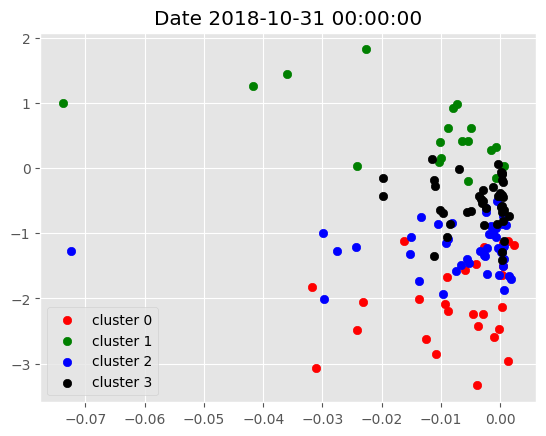

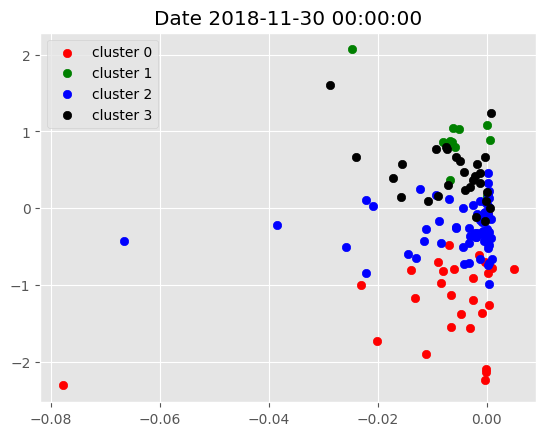

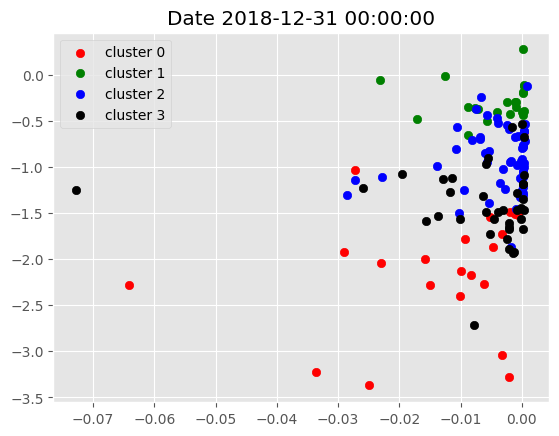

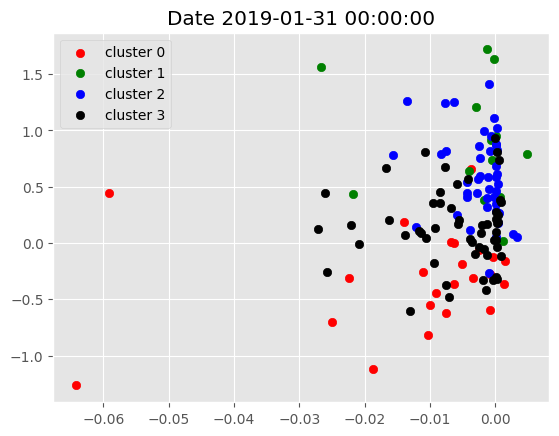

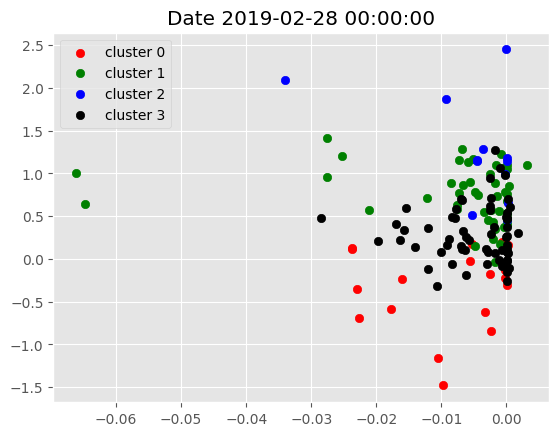

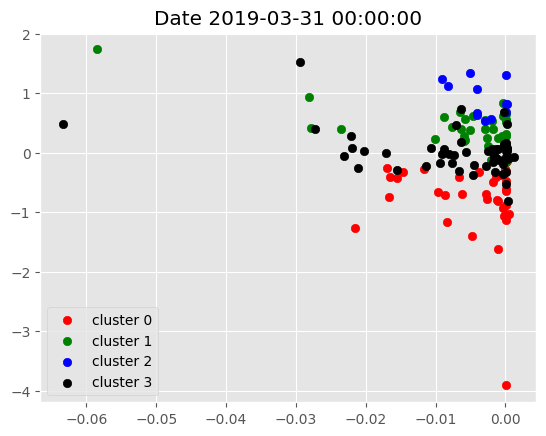

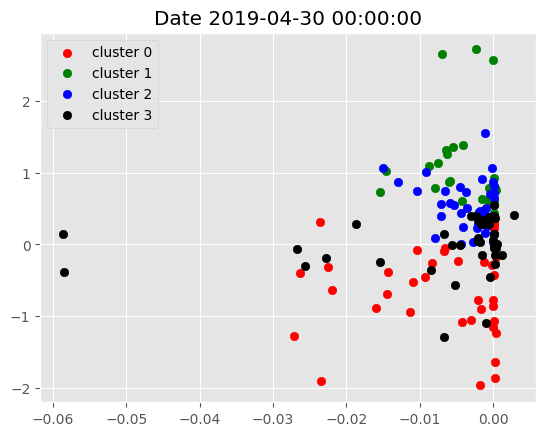

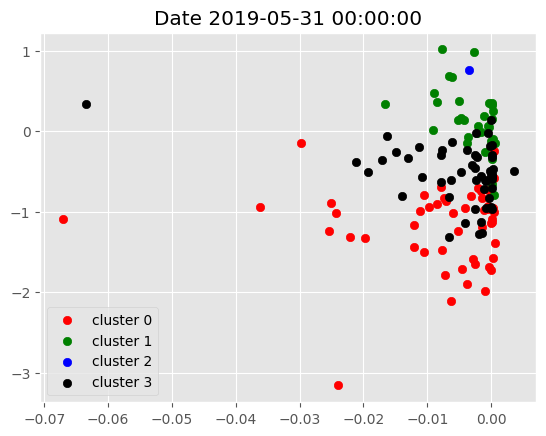

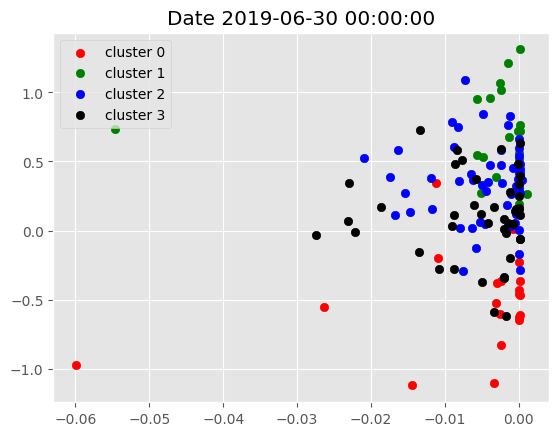

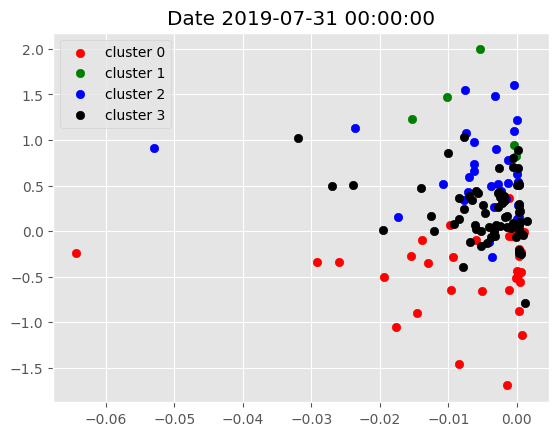

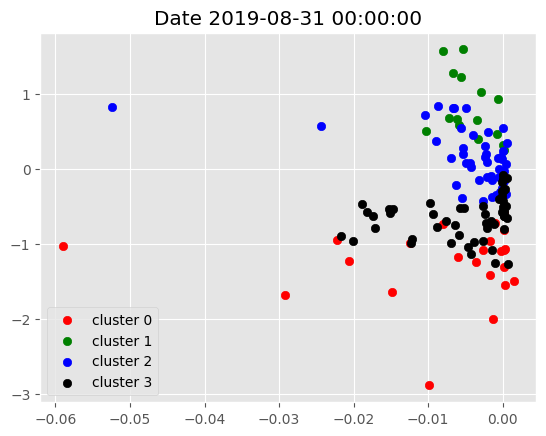

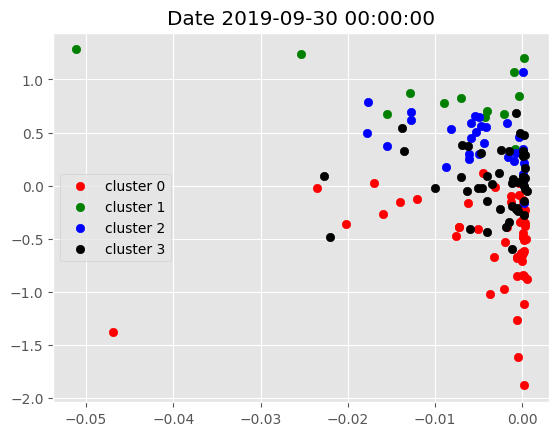

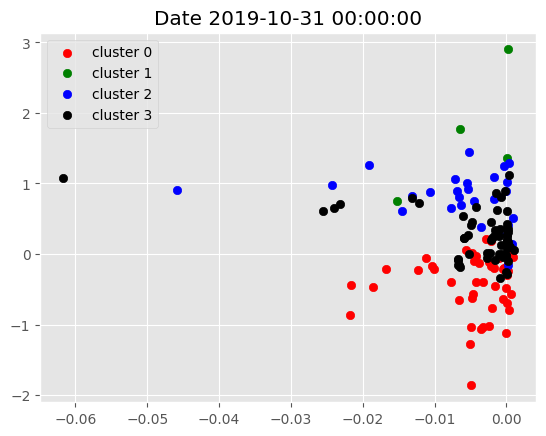

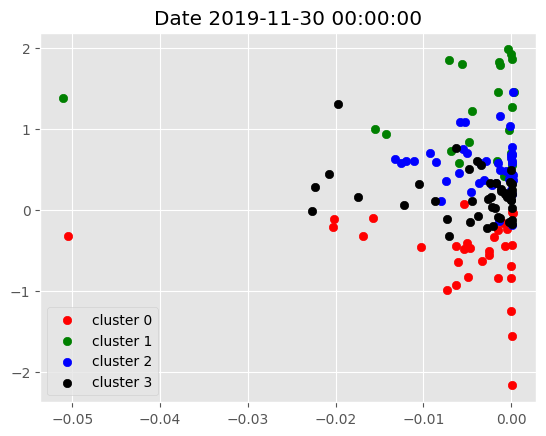

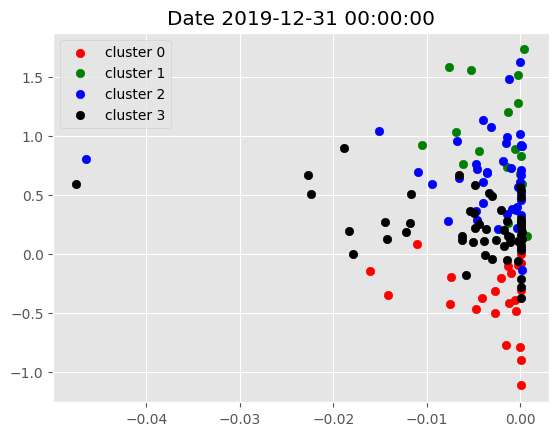

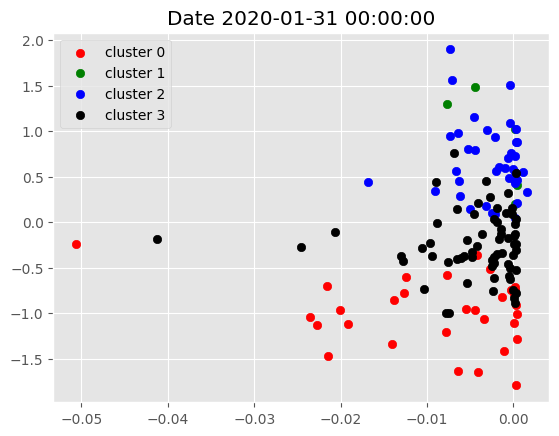

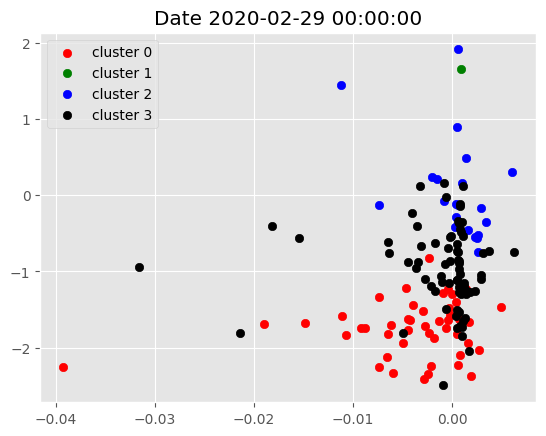

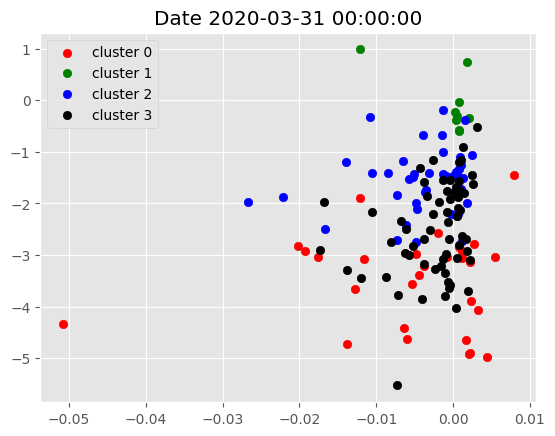

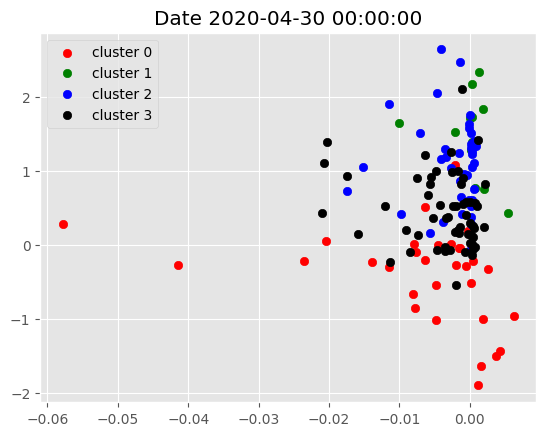

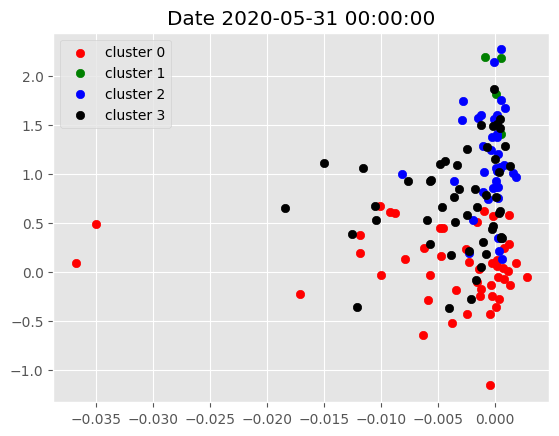

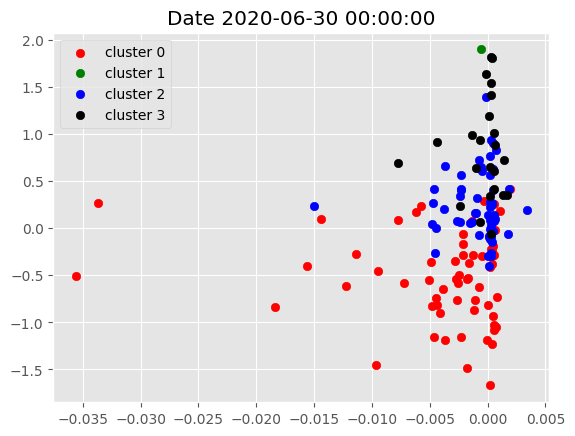

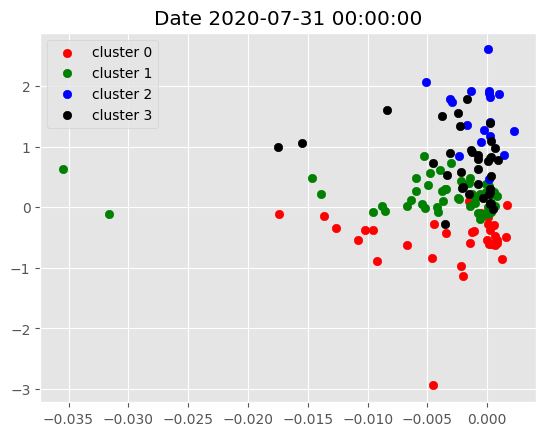

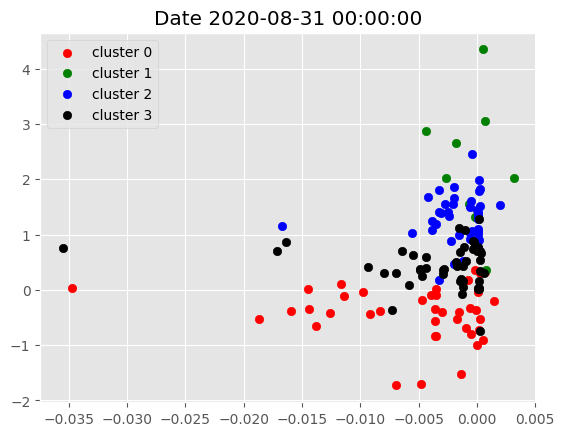

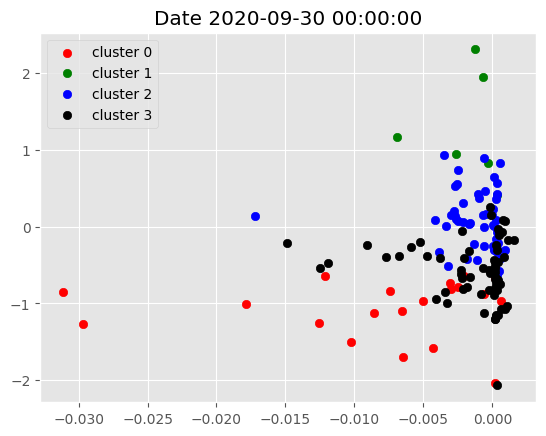

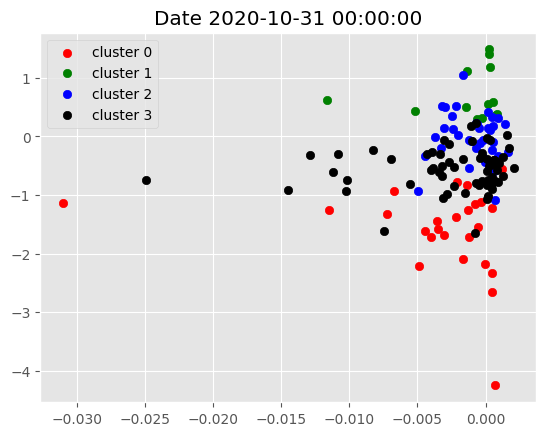

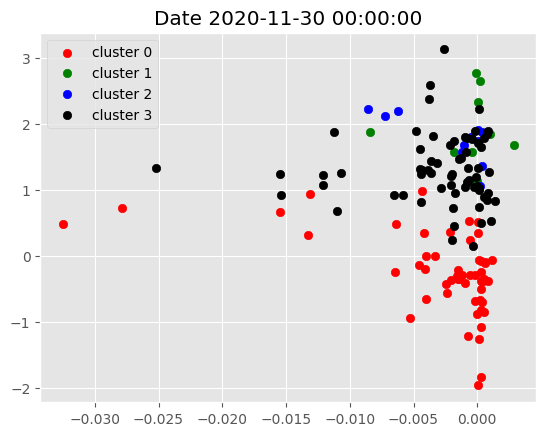

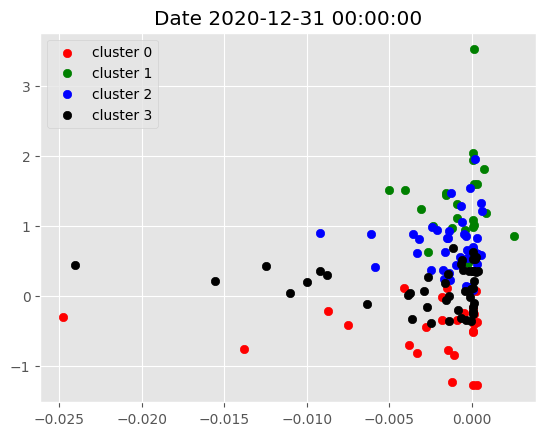

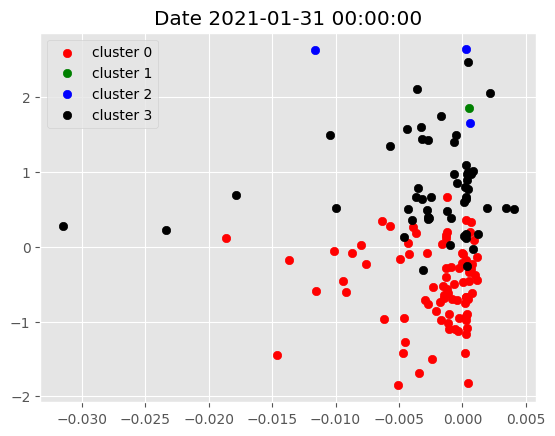

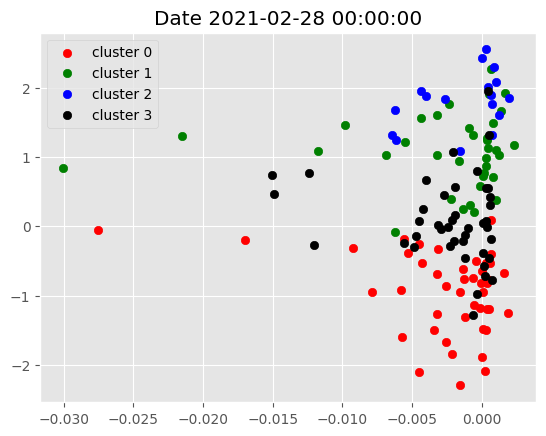

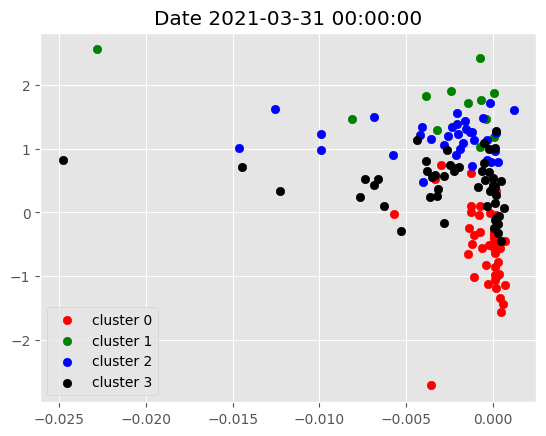

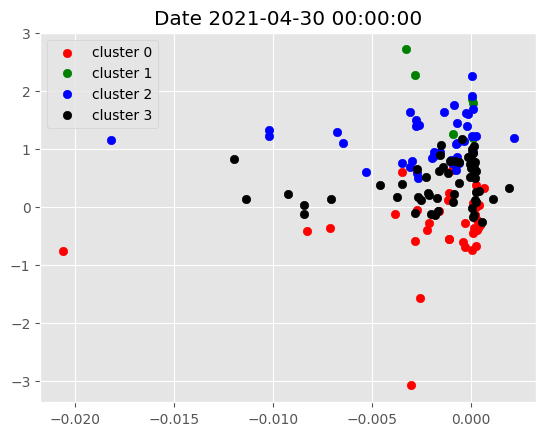

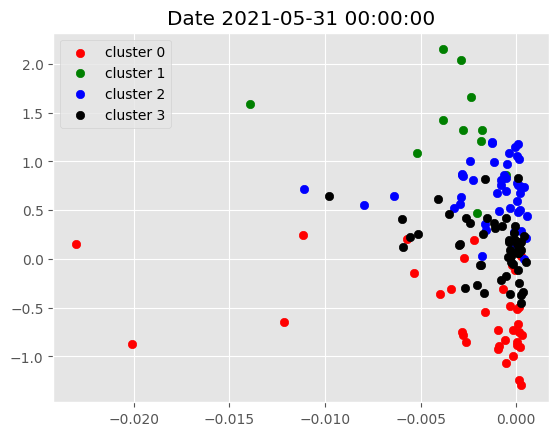

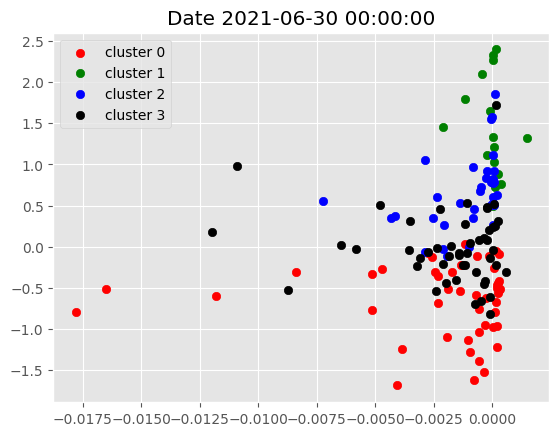

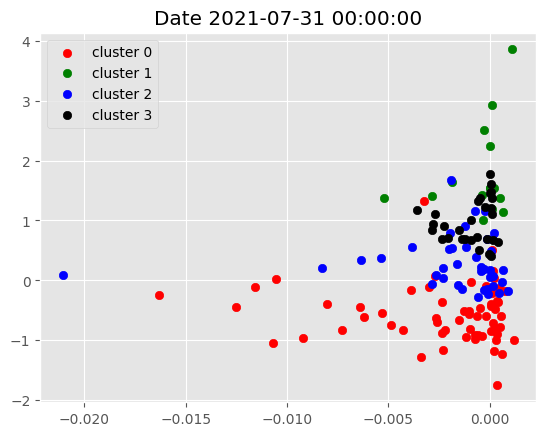

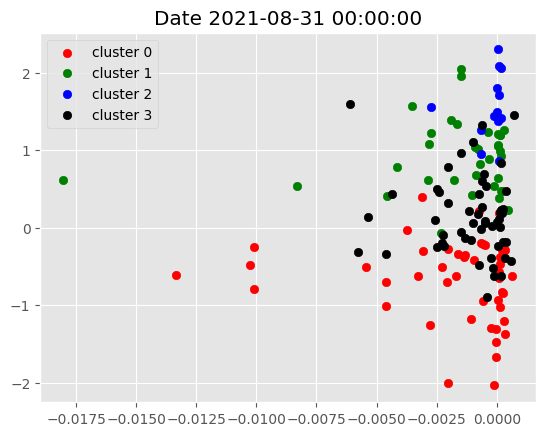

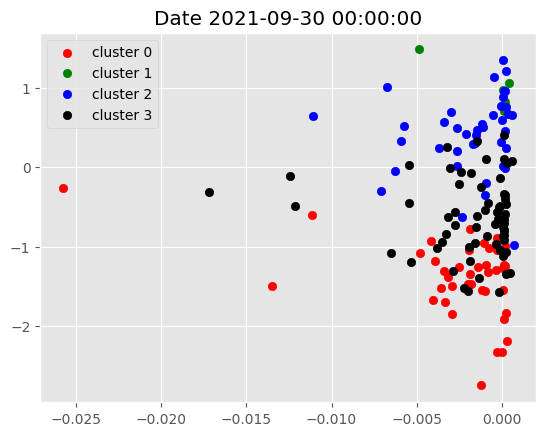

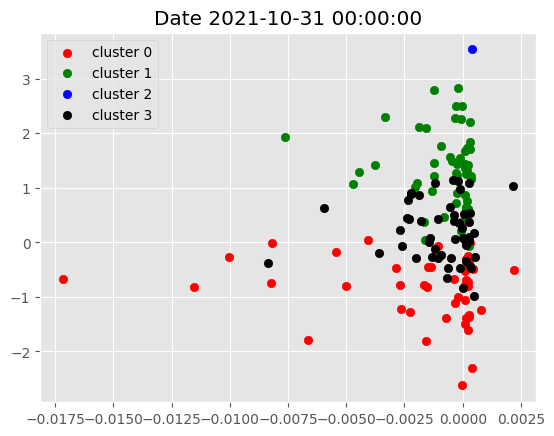

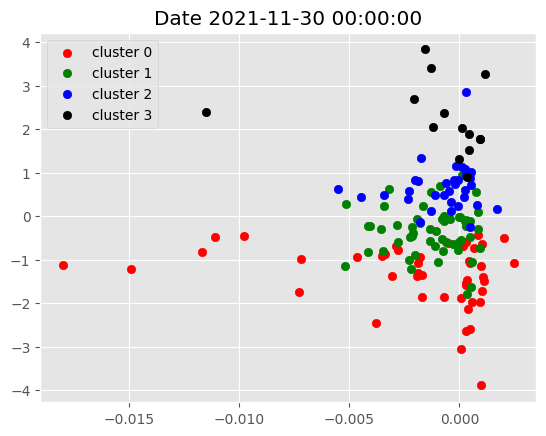

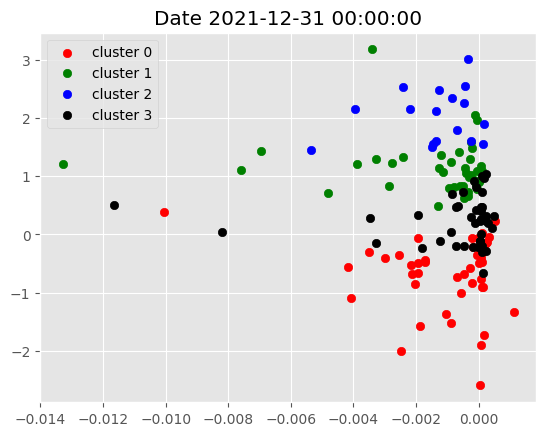

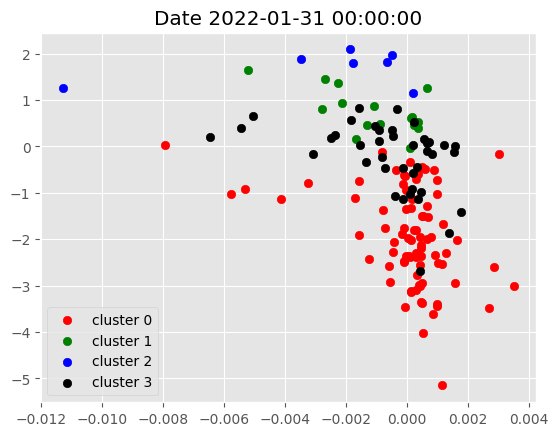

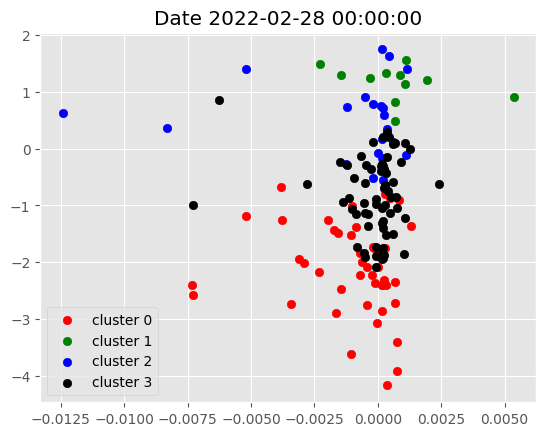

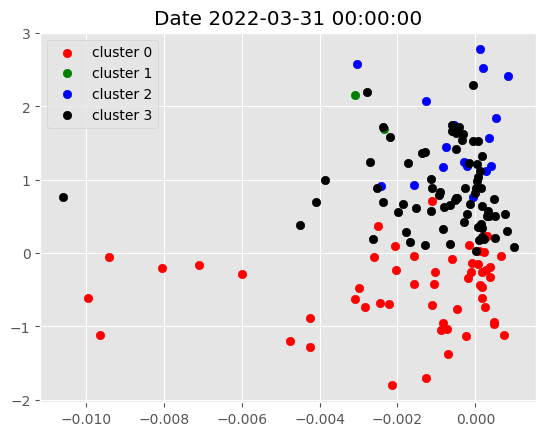

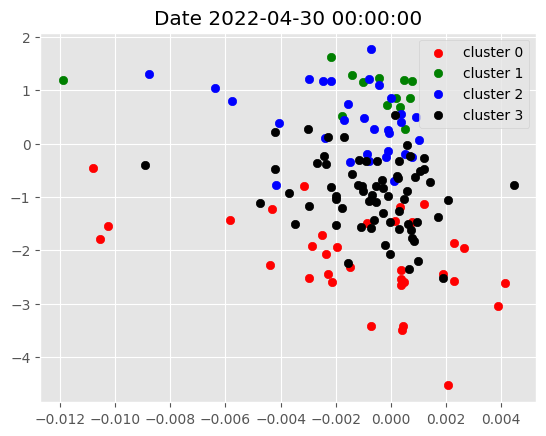

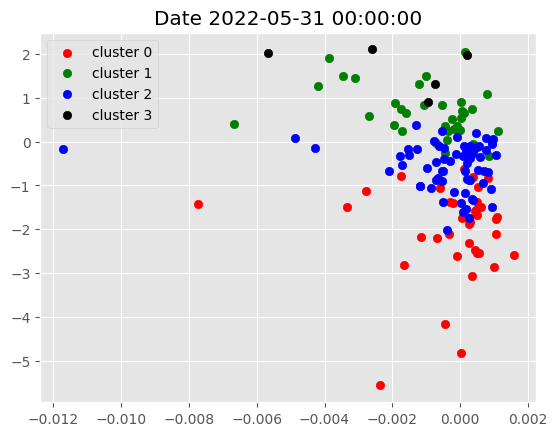

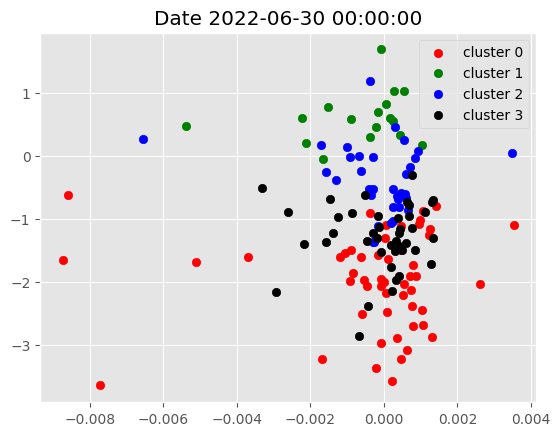

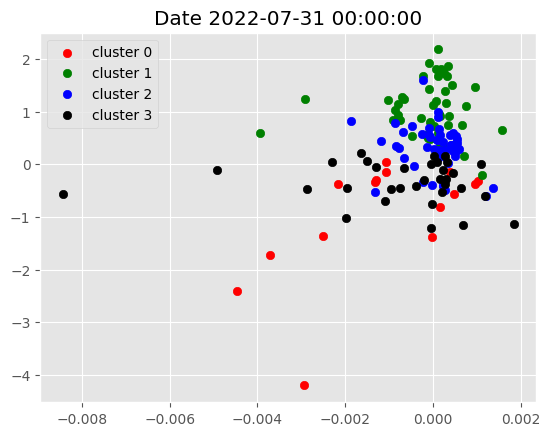

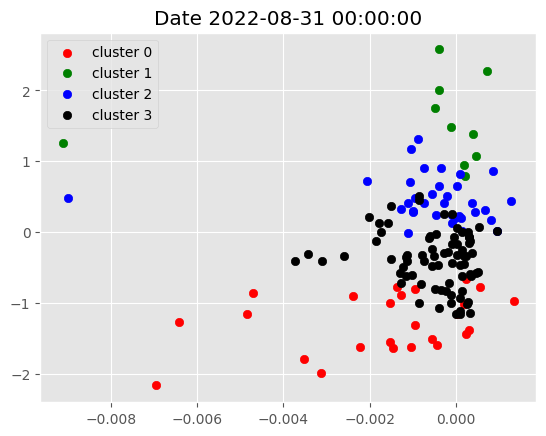

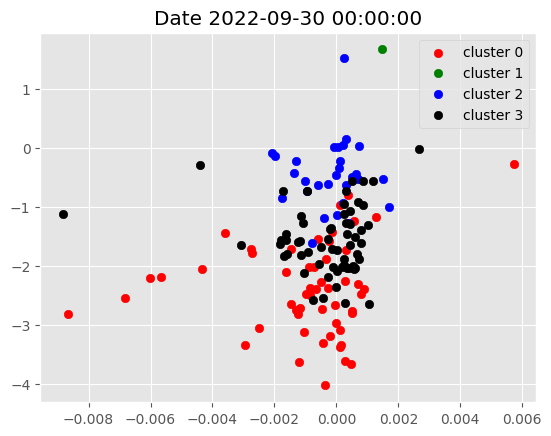

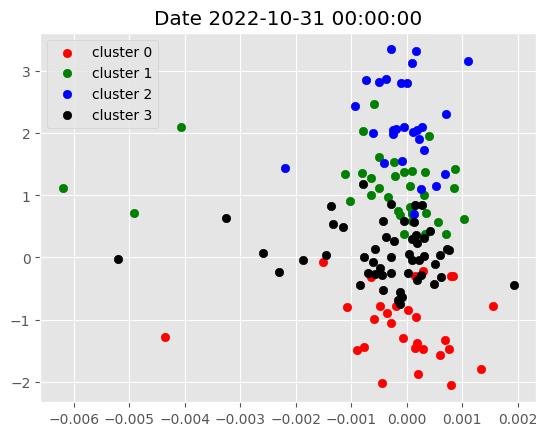

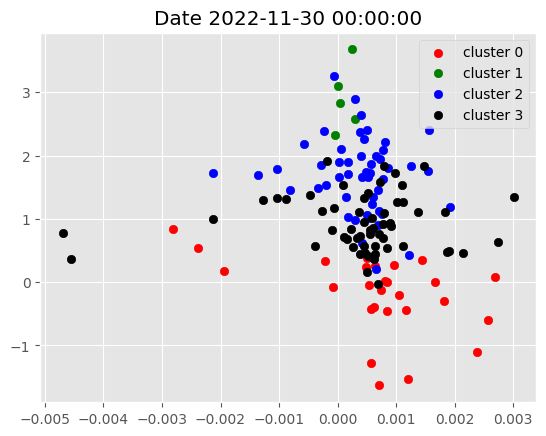

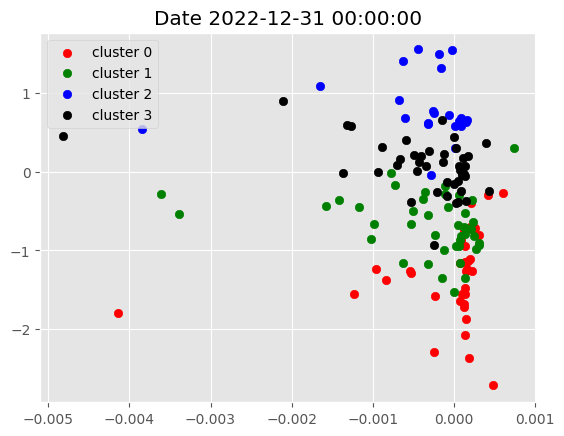

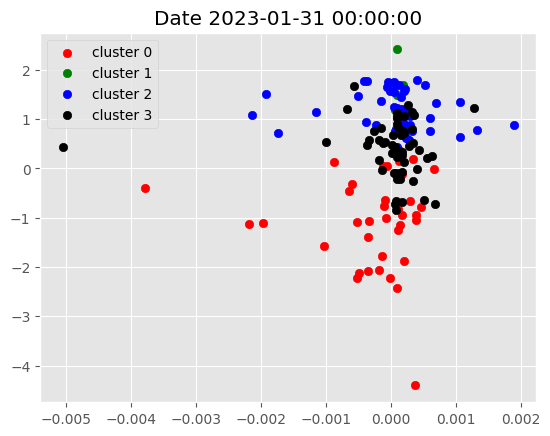

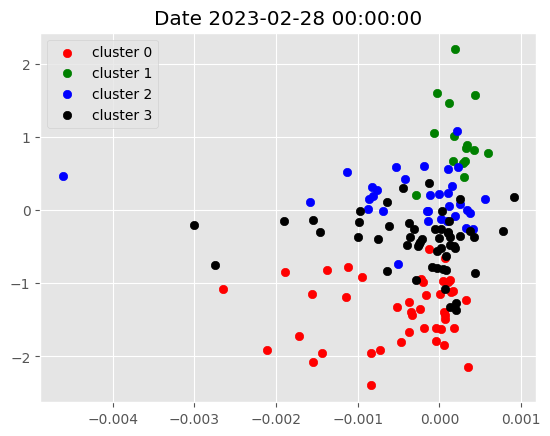

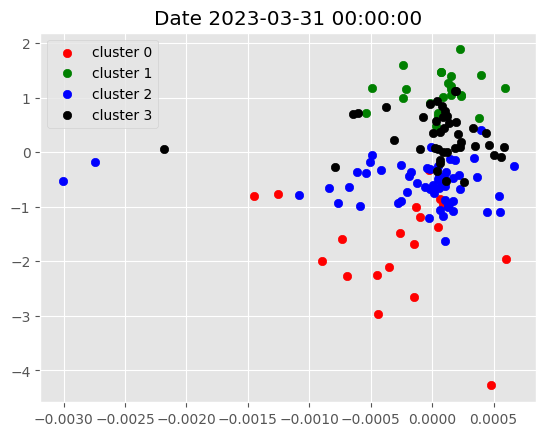

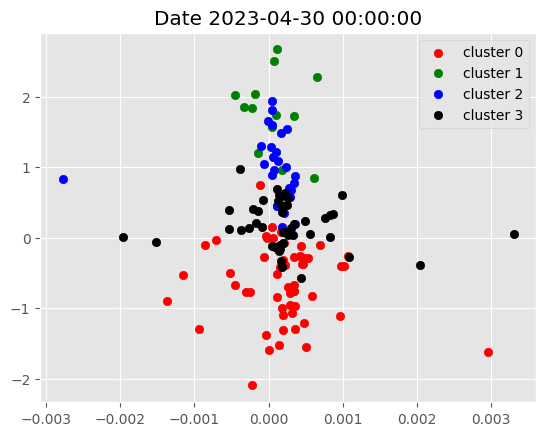

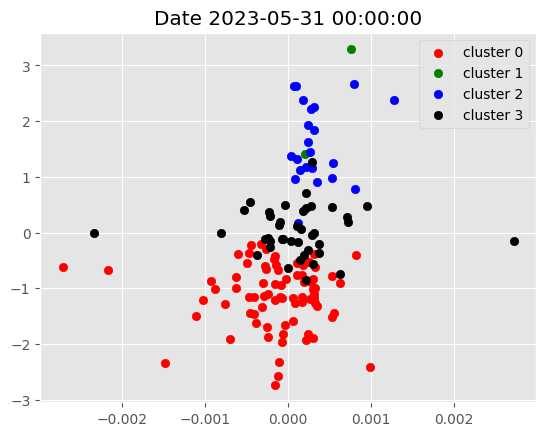

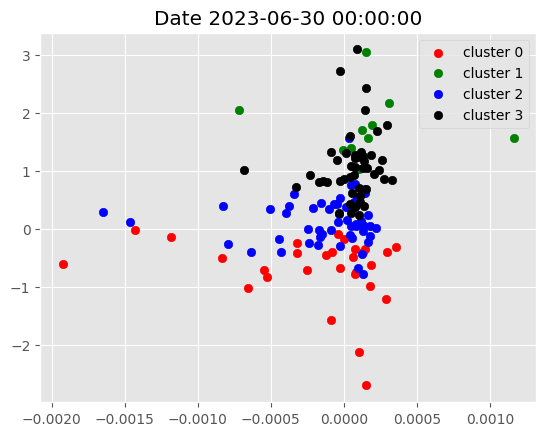

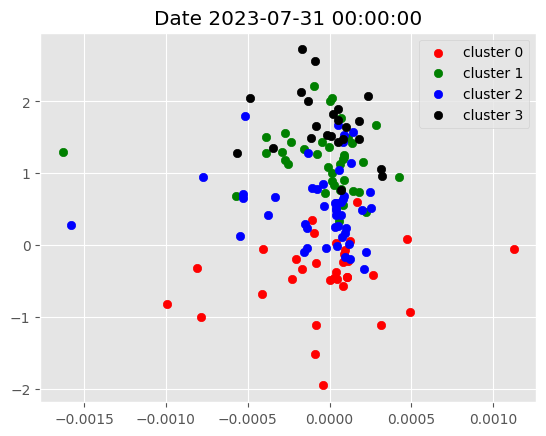

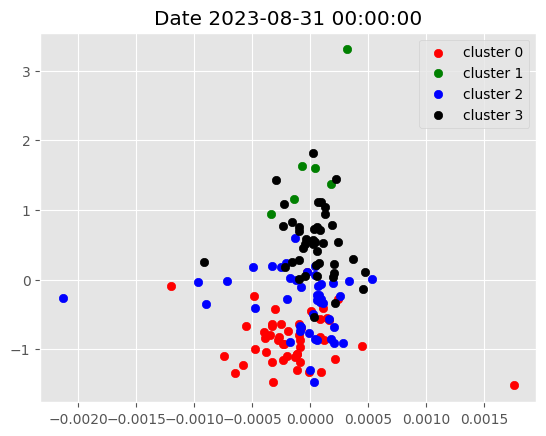

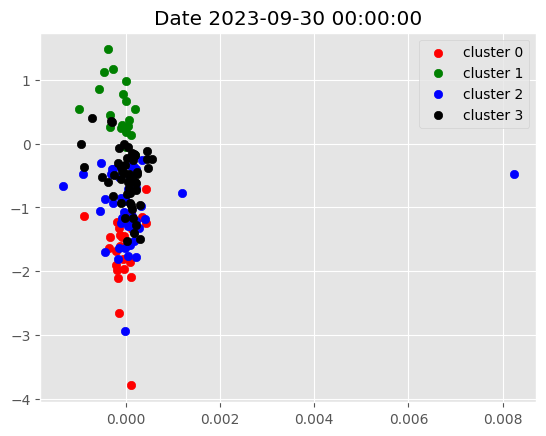

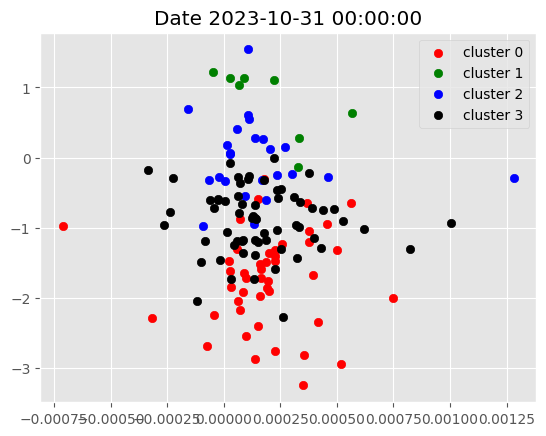

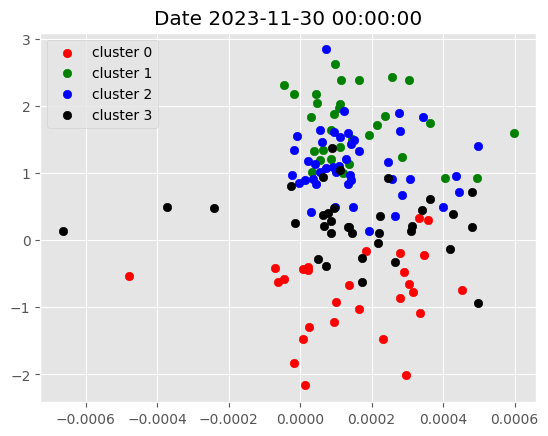

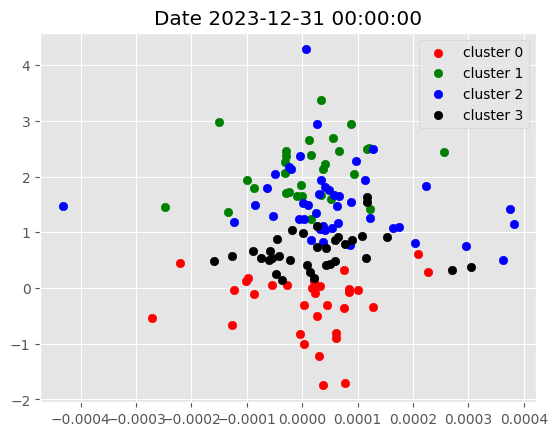

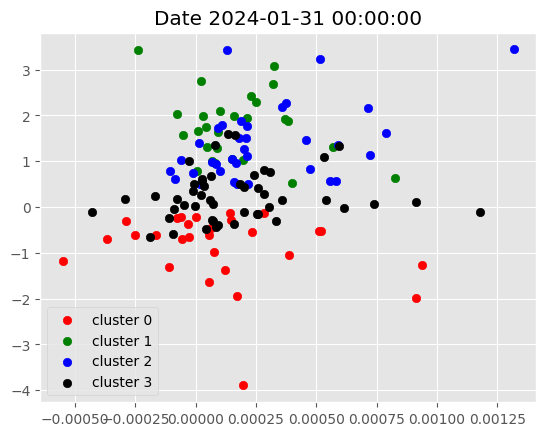

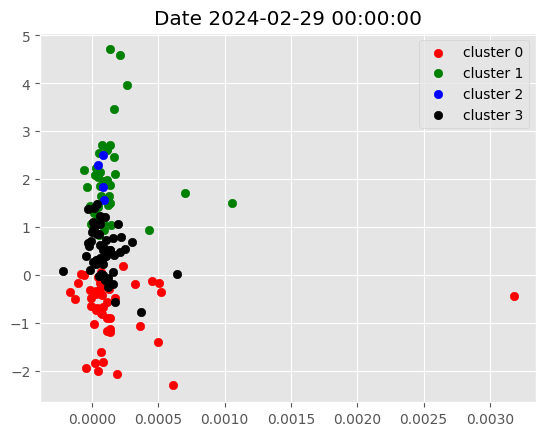

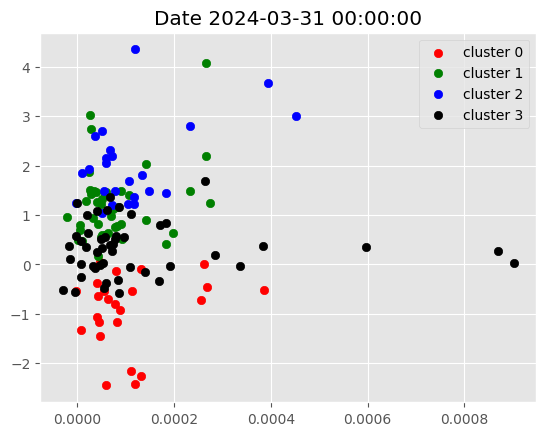

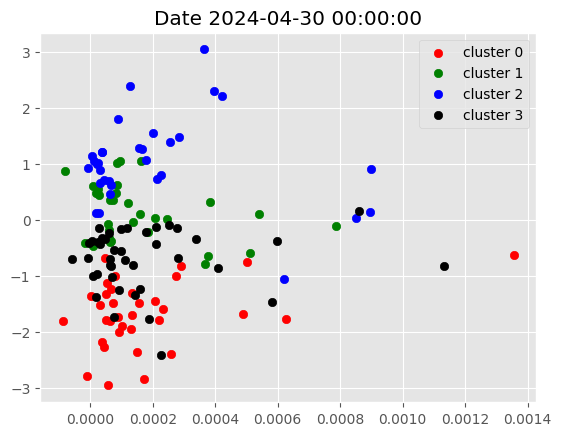

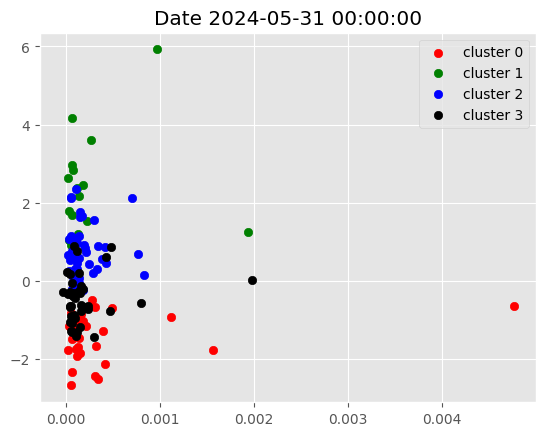

In [19]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [20]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-07-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BIIB',
  'BMY',
  'CHTR',
  'CMCSA',
  'COP',
  'CRM',
  'CSX',
  'CTSH',
  'CVX',
  'DG',
  'DIS',
  'ELV',
  'EXPE',
  'FCX',
  'GILD',
  'GOOG',
  'GOOGL',
  'HD',
  'HUM',
  'ISRG',
  'KO',
  'LLY',
  'LOW',
  'MA',
  'MDLZ',
  'MDT',
  'META',
  'MO',
  'MRK',
  'MSFT',
  'ORLY',
  'OXY',
  'PANW',
  'PFE',
  'PYPL',
  'TGT',
  'TMUS',
  'TSLA',
  'UNH',
  'UNP',
  'V',
  'VZ',
  'WFC',
  'WMT',
  'XOM'],
 '2018-08-01': ['AAL',
  'AAPL',
  'ADP',
  'AIG',
  'AMAT',
  'AMZN',
  'AXP',
  'AZO',
  'BA',
  'BIIB',
  'BRK-B',
  'CAT',
  'CHTR',
  'CI',
  'CTSH',
  'CVX',
  'DD',
  'DE',
  'DG',
  'DHR',
  'FCX',
  'FDX',
  'GE',
  'GOOGL',
  'GS',
  'HD',
  'HUM',
  'IBM',
  'ISRG',
  'LOW',
  'LRCX',
  'MGM',
  'MO',
  'MS',
  'MSFT',
  'NEE',
  'NKE',
  'ORCL',
  'OXY',
  'PNC',
  'SBUX',
  'SLB',
  'T',
  'TMUS',
  'TXN',
  'UNH',
  'V',
  'VRTX',
  'WBA',
  'WFC',
  'WYNN',
  'XOM'],
 '2018-09-01': 

## Define portfolio optimization function
- Define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

- Download Fresh Daily Prices Data only for short listed stocks.

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-06-30  48.838978   33.703407   53.369358   43.018215  111.341904   
2017-07-03  48.906921   33.581707   53.303104   43.106716  111.567001   
2017-07-05  49.751320   33.719780   53.347267   43.363358  111.675026   
2017-07-06  50.518059   33.401527   52.795261   42.425293  110.675758   
2017-07-07  51.469219   33.740849   53.016075   42.867779  111.819069   
...               ...         ...         ...         ...         ...   
2024-05-23  13.820000  186.880005  158.259995  104.230003  305.929993   
2024-05-24  13.840000  189.979996  157.059998  103.949997  300.989990   
2024-05-28  13.440000  189.990005  155.339996  101.949997  297.730011   
2024-05-29  11.620000  190.289993  154.789993  100.730003  293.769989   
2024-05-30  11.440000  191.289993  156.309998  101.739998  284.799988   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-06-30  141.440002   68.014442   88.898338  100.820000  52.191303  ...   
2017-07-03  138.410004   66.537018   88.863640   99.360001  52.834084  ...   
2017-07-05  141.210007   67.961983   90.295273  102.599998  52.408340  ...   
2017-07-06  140.750000   67.603546   89.748665  102.050003  52.658783  ...   
2017-07-07  142.220001   68.600159   91.223640  103.320000  52.884182  ...   
...                ...         ...         ...         ...        ...  ...   
2024-05-23  483.309998  233.630692  251.490005  215.160004  77.580002  ...   
2024-05-24  475.429993  231.588806  248.899994  214.889999  78.029999  ...   
2024-05-28  478.429993  232.515137  243.300003  210.449997  77.360001  ...   
2024-05-29  477.600006  227.246078  240.089996  208.509995  77.570000  ...   
2024-05-30  445.869995  229.088760  240.910004  199.929993  78.250000  ...   

Price        Volume                                                           \
Ticker            V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2017-06-30  9036600  2972000  1582300  13368900   7097300  6614900  16750700   
2017-07-03  6197700  2160000   825200   9732000   2419200  4562300  11825000   
2017-07-05  9339600  3938100  1320600  14853400   6481000  5119800  14086900   
2017-07-06  8215700  3332100  1171800  16854300   6011600  4143800  14481200   
2017-07-07  6175800  5083600  1019900  12198500   6001900  3436800  11503500   
...             ...      ...      ...       ...       ...      ...       ...   
2024-05-23  6115900  2251400  1554700  14105000  16012300  5393000  13056100   
2024-05-24  4339700  1794500  1050600  10418800  10541200  2743100   9912500   
2024-05-28  6212100  1912700  1379600  15071300  20137100  4779100  11276300   
2024-05-29  5469700  3774100   967300  17652000  21387700  7524500  12835000   
2024-05-30  4903100  3970100   975400  19636500  12134300  6287400  13584800   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-06-30  20889900  1455000  14000600  
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
...              ...      ...       ...  
2024-05-23  16222900  1465100  15979800  
2024-05-24  11793800  1035400  12211400  
2024-05-28  13349600  1812400  13978300  
2024-05-29  11538600  2367700  13902000  
2024-05-30  13053500  1219100  14692000  

[1740 rows x 936 columns]

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.

In [27]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_dfreturns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_dfreturns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index()\
               .merge(weights.stack().to_frame('weight').reset_index(),
                      left_on='level_0',
                      right_on='level_0')\
               .set_index(['level_0', 'level_1']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in

""
